In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
import scipy

In [2]:
# project files

from utils.variables import pack, unpack
from utils.display import table, tabulate
from utils.files import download_sheet, save, load
from utils.hash import digest

from fit_options import fit_options
from game_model import game
from rp_model import compute_rp, make_precomputed_columns
from initial_guess import make_initial_guess

In [3]:
# stuff for display

from IPython.lib.pretty import pretty, pprint

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 120)

In [4]:
data = pd.read_pickle(fit_options.data_file)
data.describe()
data.head()

,Level,RP,MS lvl,ModelRP,Difference,Freq1,FreqL,Inv,Berry1,BerryL,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,BerryD,IngD,Dupes,Amnt,Ing2P,Help skill bonus,RP Multiplier
count,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.00000,6326.000000,6326.000000,6326.0,6326.000000,6326.000000,6326.000000,6326.000000
mean,10.600221,604.489251,1.490831,604.527087,0.037836,3957.192539,3807.605275,12.229529,28.040942,37.740120,108.840500,1.017855,0.988552,0.994790,1.000917,1.005375,0.207831,32.57993,55.241385,148.778375,1.0,0.072400,2.962536,0.987673,1.028040
std,7.144162,388.638606,0.982291,388.693660,0.962510,962.301896,1023.063474,3.385034,2.611147,8.005598,15.997332,0.303530,0.059303,0.044976,0.117870,0.118527,0.044906,36.08216,27.687375,60.605390,0.0,0.511503,20.447361,0.037609,0.070145
min,1.000000,245.000000,1.000000,245.060000,-11.980000,2200.000000,1489.118400,7.000000,24.000000,24.000000,90.000000,0.520000,0.890000,0.920000,0.800000,0.800000,0.130000,5.88000,25.000000,90.000000,1.0,0.000000,0.000000,0.790000,1.000000
25%,5.000000,355.000000,1.000000,354.635000,-0.280000,3300.000000,2955.960000,10.000000,26.000000,32.000000,98.000000,0.800000,1.000000,1.000000,1.000000,1.000000,0.180000,12.81000,35.000000,101.000000,1.0,0.000000,0.000000,1.000000,1.000000
50%,10.000000,462.000000,1.000000,461.845000,-0.010000,3900.000000,3792.400000,12.000000,28.000000,36.000000,103.000000,0.940000,1.000000,1.000000,1.000000,1.000000,0.200000,19.98000,45.000000,121.000000,1.0,0.000000,0.000000,1.000000,1.000000
75%,14.000000,712.000000,2.000000,711.970000,0.270000,4500.000000,4455.000000,14.000000,31.000000,42.000000,115.000000,1.210000,1.000000,1.000000,1.000000,1.000000,0.240000,43.98000,68.000000,202.000000,1.0,0.000000,0.000000,1.000000,1.000000
max,42.000000,3440.000000,6.000000,3440.430000,10.460000,6300.000000,6916.140000,23.000000,35.000000,77.000000,151.000000,2.410000,1.120000,1.080000,1.200000,1.200000,0.420000,413.95000,222.000000,511.000000,1.0,8.000000,342.000000,1.000000,1.440000


,Pokemon,Level,RP,Nature,MS lvl,Source,ModelRP,Difference,Nature2,ID,NatureP,NatureN,Freq1,FreqL,Type,Class,MSkill,Inv,Berry1,BerryL,Ing1,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,RPneutral,IDNeutral,BerryD,IngD,Dupes,DupeMatch,Sub Skill 1,Sub Skill 2,Ingredient 2,Amnt,Ing2P,Help skill bonus,RP Multiplier
0,Arbok,9.0,574.0,Naughty,1.0,Rate My Mon,574.42,0.42,Naughty,ArbokNaughty91,Speed of Help,Main Skill Chance,3700.0,3276.72,Poison,Berries,Charge Energy S,14.0,32.0,40,Bean Sausage,103.0,1.09,0.90,1.00,1.0,0.8,0.26,22.76,538.36,ArbokNeutral91,80.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
1,Arbok,8.0,531.0,Hardy,1.0,Questions help guides,530.70,-0.30,Neutral,ArbokNeutral81,-,-,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.00,1.00,1.0,1.0,0.26,22.76,531.00,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
2,Arbok,8.0,538.0,Quiet,1.0,Questions help guides,538.09,0.09,Quiet,ArbokQuiet81,Ingredient Finding,Exp Gains,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.00,1.00,1.2,1.0,0.26,22.76,530.61,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
3,Arcanine,5.0,958.0,Calm,3.0,,957.90,-0.10,Calm,ArcanineCalm53,Main Skill Chance,Speed of Help,2500.0,2728.00,Fire,Skills,Extra Helpful S,16.0,27.0,31,Fiery Herb,130.0,1.31,1.11,1.00,1.0,1.2,0.14,84.50,937.84,ArcanineNeutral53,31.0,130.0,1,True,,,,0.0,0.0,1.0,1.0
4,Arcanine,3.0,715.0,Lax,2.0,pokemon sleep general,714.77,-0.23,Lax,ArcanineLax32,Energy Recovery,Main Skill Chance,2500.0,2490.00,Fire,Skills,Extra Helpful S,16.0,27.0,29,Fiery Herb,130.0,1.44,1.00,1.08,1.0,0.8,0.14,61.21,750.21,ArcanineNeutral32,29.0,130.0,1,True,,,,0.0,0.0,1.0,1.0


In [5]:
# Make an initial guess
# Pack the dictionary into a 1-D vector.
# Also store information on how to unpack that vector

x0, unpack_info = pack(make_initial_guess())
computed = make_precomputed_columns(data)

In [6]:
# We compute the RP model in rp_model.py
# Here we create closure to glue the pieces together.

def RP(x):
    return compute_rp(x, data, computed, unpack_info)

# for the error analysis page,
# we'll compute the residual with exact rounding.

def residual(x):
    return data["RP"] - np.round(RP(x))


In [7]:
filename = fit_options.result_file(digest(data, x0))
opt = load(filename)
sol = unpack(opt.x, unpack_info)

opt

    message: The maximum number of function evaluations is exceeded.
    success: False
     status: 0
          x: [ 2.521e-01  2.502e-01 ...  2.199e-01  2.199e-01]
       cost: 4144.405211938394
       grad: [ 1.476e+03  4.234e+03 ... -9.749e+03 -7.575e+04]
 optimality: 9211562.42645229
       nfev: 200
       njev: 14

In [8]:
# What are the worst points?

df = data[["Pokemon","ID","Level","Class","Inv","MS lvl","NatureP","NatureN","Sub Skill 1","Sub Skill 2","RP"]].copy()

df["fit"] = np.round(RP(opt.x))
df["error"] = residual(opt.x)
df["error2"] = df["error"]**2

df = df.sort_values("error2", ascending = False)
df.head(100)

,Pokemon,ID,Level,Class,Inv,MS lvl,NatureP,NatureN,Sub Skill 1,Sub Skill 2,RP,fit,error,error2
2556,Swalot,SwalotNeutral254Helping bonusSkill Trigger M,25.0,Skills,13.0,4.0,-,-,Helping bonus,Skill Trigger M,1768.0,1788.0,-20.0,400.0
2569,Sylveon,SylveonGentle256Helping bonusSkill Level Up M,25.0,Skills,15.0,6.0,Main Skill Chance,Energy Recovery,Helping bonus,Skill Level Up M,2757.0,2769.0,-12.0,144.0
2609,Togekiss,TogekissGentle275Research EXP BonusHelping bonus,27.0,Skills,16.0,5.0,Main Skill Chance,Energy Recovery,Research EXP Bonus,Helping bonus,2651.0,2663.0,-12.0,144.0
398,Charizard,CharizardMild276Helping Speed MSkill Level Up M,27.0,Ingredients,19.0,6.0,Ingredient Finding,Energy Recovery,Helping Speed M,Skill Level Up M,1514.0,1503.0,11.0,121.0
2607,Togekiss,TogekissGentle245Research EXP Bonus,24.0,Skills,16.0,5.0,Main Skill Chance,Energy Recovery,Research EXP Bonus,,2208.0,2218.0,-10.0,100.0
2603,Togekiss,TogekissGentle103Skill Trigger M,10.0,Skills,16.0,3.0,Main Skill Chance,Energy Recovery,Skill Trigger M,,1282.0,1272.0,10.0,100.0
2727,Typhlosion,TyphlosionCareful273Berry Finding SHelping Spe...,27.0,Berries,23.0,3.0,Main Skill Chance,Ingredient Finding,Berry Finding S,Helping Speed M,1761.0,1751.0,10.0,100.0
427,Charizard,CharizardRash273Helping bonusHelping Speed M,27.0,Ingredients,19.0,3.0,Ingredient Finding,Main Skill Chance,Helping bonus,Helping Speed M,1440.0,1431.0,9.0,81.0
178,Blastoise,BlastoiseGentle324Skill Trigger MSleep EXP Bonus,32.0,Ingredients,17.0,4.0,Main Skill Chance,Energy Recovery,Skill Trigger M,Sleep EXP Bonus,1878.0,1887.0,-9.0,81.0
2801,Victreebel,VictreebelNeutral313Energy Recovery BonusInven...,31.0,Ingredients,17.0,3.0,-,-,Energy Recovery Bonus,Inventory Up M,1713.0,1704.0,9.0,81.0


intercept,0.0155689
intercept_stderr,0.0260268
pvalue,0.245772
rvalue,-0.0145952
slope,-0.00236349
stderr,0.00203611


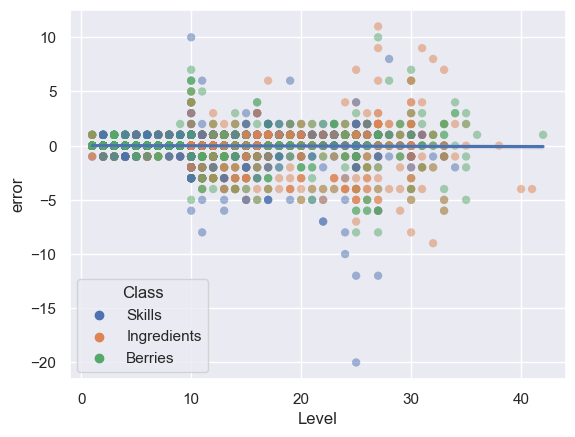

In [9]:
# Plot error vs level

err = df[["Level","error","Class"]]
palette = sns.color_palette(n_colors=3)

_ = sns.scatterplot(data=err, x="Level", y="error", hue="Class", alpha=0.5, linewidth=0, palette=palette)
_ = sns.regplot(data=err, x="Level", y="error", scatter=False)

# What is the slope ?
linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])
table(linearfit)

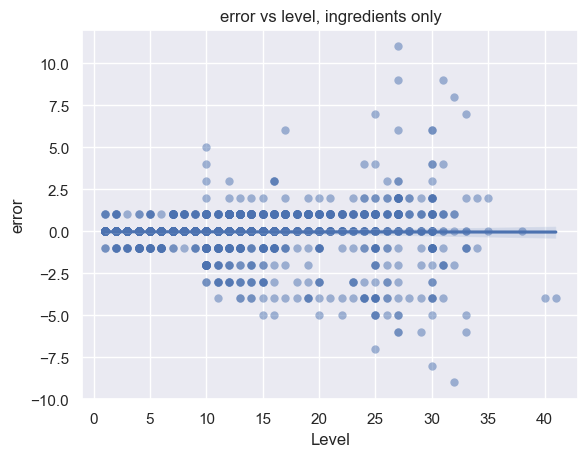

In [10]:
err2 = err[ err["Class"]=="Ingredients" ]
p = sns.scatterplot(data=err2, x="Level", y="error", alpha=0.5, linewidth=0, color=palette[0])
_ = sns.regplot(data=err2, x="Level", y="error", scatter=False)
_ = p.set(title='error vs level, ingredients only')


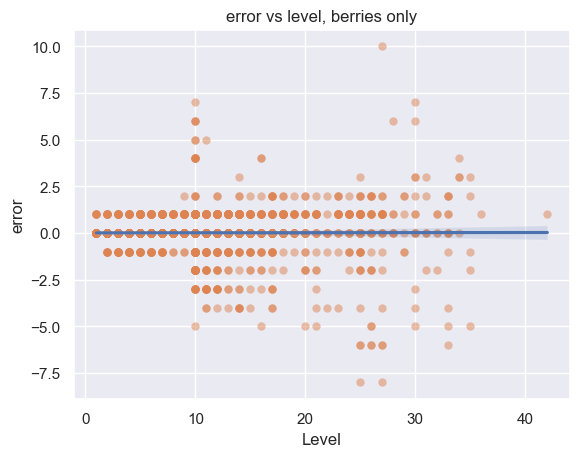

In [11]:
err2 = err[ err["Class"]=="Berries" ]
p = sns.scatterplot(data=err2, x="Level", y="error", alpha=0.5, linewidth=0, color=palette[1])
_ = sns.regplot(data=err2, x="Level", y="error", scatter=False)
_ = p.set(title='error vs level, berries only')

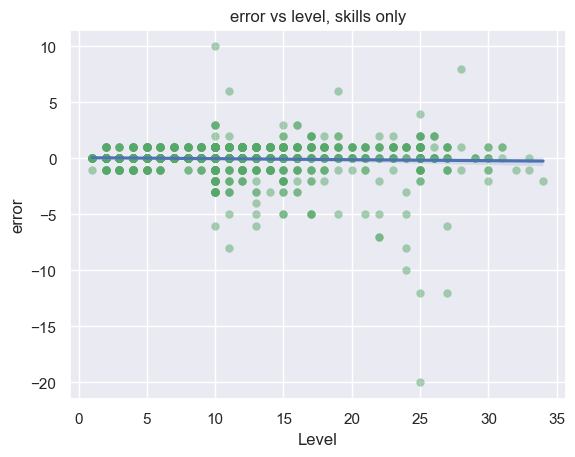

In [12]:
err2 = err[ err["Class"]=="Skills" ]

p = sns.scatterplot(data=err2, x="Level", y="error", alpha=0.5, linewidth=0, color=palette[2])
_ = sns.regplot(data=err2, x="Level", y="error", scatter=False)
_ = p.set(title='error vs level, skills only')


intercept,-0.00437449
intercept_stderr,0.0201023
pvalue,0.523768
rvalue,-0.00940964
slope,-0.00138583
stderr,0.00217353


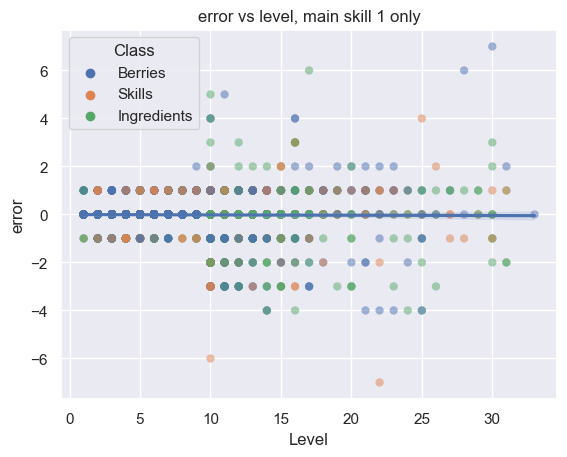

In [13]:
# Plot error vs level - focus on main skill 1

err = df[["Level","error","Class"]].loc[df["MS lvl"]==1]

p = sns.scatterplot(data=err, x="Level", y="error", hue="Class", alpha=0.5, linewidth=0)
_ = sns.regplot(data=err, x="Level", y="error", scatter=False)

_ = p.set(title='error vs level, main skill 1 only')

# What is the slope ?
linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])
table(linearfit)

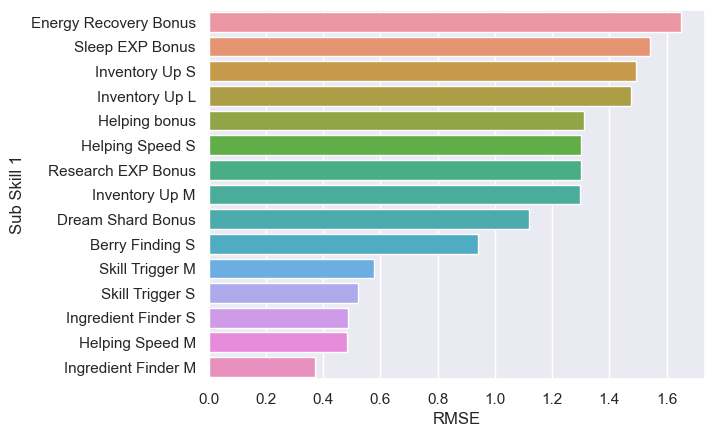

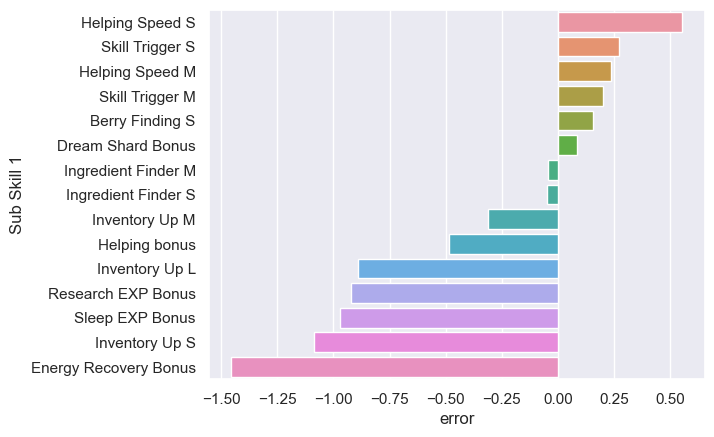

In [14]:
# Let's see what happens at level 10 and main skill 1

subskill_err = ( df[["Level", "Sub Skill 1", "error", "error2"]].loc[ (df["Level"]==10) & (df["MS lvl"]==1) ]
                .groupby("Sub Skill 1")
                .mean()
                .sort_values("error2", ascending = False)
                .reset_index() )

subskill_err["RMSE"] = np.sqrt(subskill_err["error2"])

_ = plt.figure()
_ = sns.barplot(data=subskill_err, y="Sub Skill 1", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=subskill_err.sort_values("error", ascending = False), y="Sub Skill 1", x="error")


intercept,-0.00437449
intercept_stderr,0.0201023
pvalue,0.523768
rvalue,-0.00940964
slope,-0.00138583
stderr,0.00217353


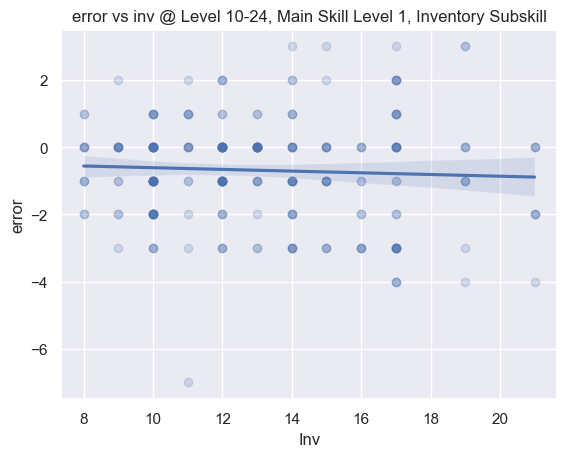

In [15]:
# Let's see what happens at level 10-24, main skill 1, and inventory bonus 

inventory_err = ( df[["Level", "Inv", "Sub Skill 1", "error", "error2"]] 
                 .loc[ (df["Level"]<25) & (df["MS lvl"]==1) & ( df["Sub Skill 1"].str.contains("Inventory")) ]
                )

p = sns.regplot(data=inventory_err, x="Inv", y="error", x_jitter=0, scatter_kws={'alpha':0.2})

_ = p.set(title='error vs inv @ Level 10-24, Main Skill Level 1, Inventory Subskill')

linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])
table(linearfit)

intercept,-0.00437449
intercept_stderr,0.0201023
pvalue,0.523768
rvalue,-0.00940964
slope,-0.00138583
stderr,0.00217353


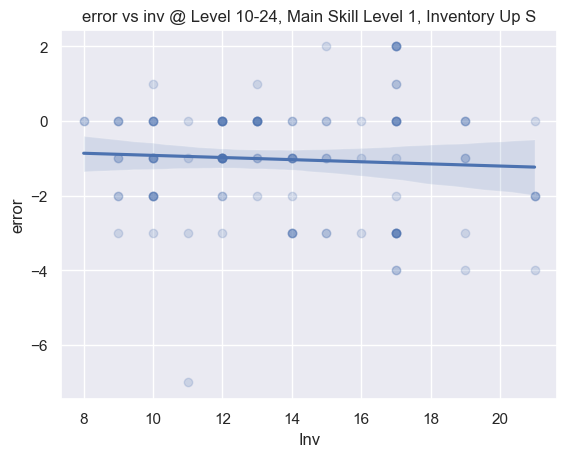

In [16]:
# Let's see what happens at level 10-24, main skill 1, and inventory bonus

inventory_err = ( df[["Level", "Inv", "Sub Skill 1", "error", "error2"]]
                 .loc[ (df["Level"]<25) & (df["MS lvl"]==1) & ( df["Sub Skill 1"] == "Inventory Up S" ) ]
                )

p = sns.regplot(data=inventory_err, x="Inv", y="error", x_jitter=0, scatter_kws={'alpha':0.2})

_ = p.set(title='error vs inv @ Level 10-24, Main Skill Level 1, Inventory Up S')

linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])
table(linearfit)

intercept,-0.00437449
intercept_stderr,0.0201023
pvalue,0.523768
rvalue,-0.00940964
slope,-0.00138583
stderr,0.00217353


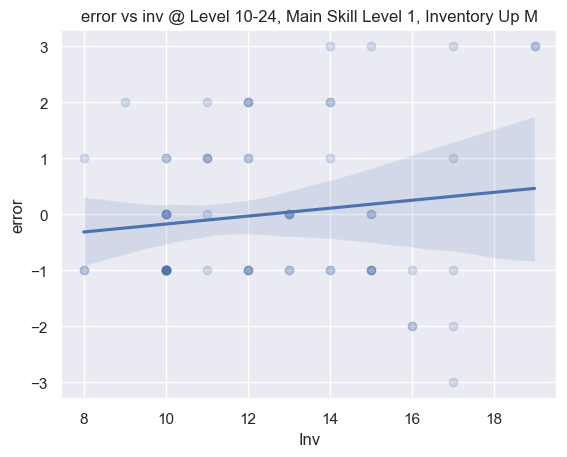

In [17]:
# Let's see what happens at level 10-24, main skill 1, and inventory bonus

inventory_err = ( df[["Level", "Inv", "Sub Skill 1", "error", "error2"]]
                 .loc[ (df["Level"]<25) & (df["MS lvl"]==1) & ( df["Sub Skill 1"] == "Inventory Up M" ) ]
                )

p = sns.regplot(data=inventory_err, x="Inv", y="error", x_jitter=0, scatter_kws={'alpha':0.2})

_ = p.set(title='error vs inv @ Level 10-24, Main Skill Level 1, Inventory Up M')

linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])
table(linearfit)

In [18]:
df[["Level", "Inv","NatureP","NatureN", "Sub Skill 1", "error", "error2"]].loc[ (df["Level"]<25) & (df["MS lvl"]==1) & ( df["Sub Skill 1"] == "Inventory Up M" )  & (df["error2"] > 1)]


,Level,Inv,NatureP,NatureN,Sub Skill 1,error,error2
2026,16.0,19.0,Energy Recovery,Ingredient Finding,Inventory Up M,3.0,9.0
2027,16.0,19.0,Energy Recovery,Main Skill Chance,Inventory Up M,3.0,9.0
1430,16.0,15.0,Speed of Help,Energy Recovery,Inventory Up M,3.0,9.0
1825,12.0,17.0,Main Skill Chance,EXP Gains,Inventory Up M,-3.0,9.0
2804,16.0,17.0,Energy Recovery,EXP Gains,Inventory Up M,3.0,9.0
2883,12.0,14.0,Energy Recovery,Main Skill Chance,Inventory Up M,3.0,9.0
2523,10.0,12.0,Energy Recovery,Ingredient Finding,Inventory Up M,2.0,4.0
383,16.0,11.0,Energy Recovery,Main Skill Chance,Inventory Up M,2.0,4.0
2206,10.0,16.0,Main Skill Chance,Speed of Help,Inventory Up M,-2.0,4.0
1591,10.0,9.0,Energy Recovery,Speed of Help,Inventory Up M,2.0,4.0


intercept,-0.00437449
intercept_stderr,0.0201023
pvalue,0.523768
rvalue,-0.00940964
slope,-0.00138583
stderr,0.00217353


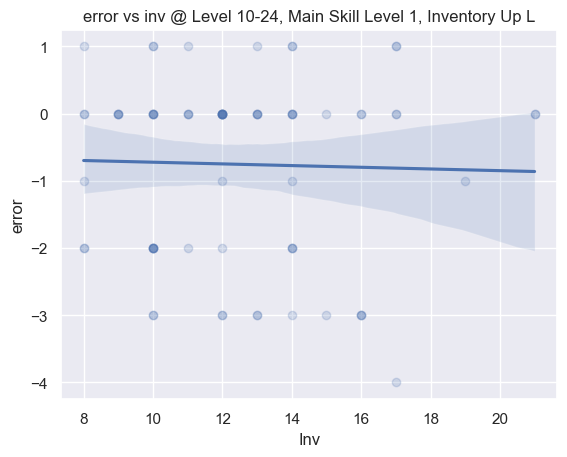

In [19]:
# Let's see what happens at level 10-24, main skill 1, and inventory bonus

inventory_err = ( df[["Level", "Inv", "Sub Skill 1", "error", "error2"]]
                 .loc[ (df["Level"]<25) & (df["MS lvl"]==1) & ( df["Sub Skill 1"] == "Inventory Up L" ) ]
                )

p = sns.regplot(data=inventory_err, x="Inv", y="error", x_jitter=0, scatter_kws={'alpha':0.2})

_ = p.set(title='error vs inv @ Level 10-24, Main Skill Level 1, Inventory Up L')

linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])
table(linearfit)

[Text(0.5, 1.0, 'error vs inv @ Level 10-24, Main Skill Level 1, Not Inventory Subskill')]

intercept,-0.00437449
intercept_stderr,0.0201023
pvalue,0.523768
rvalue,-0.00940964
slope,-0.00138583
stderr,0.00217353


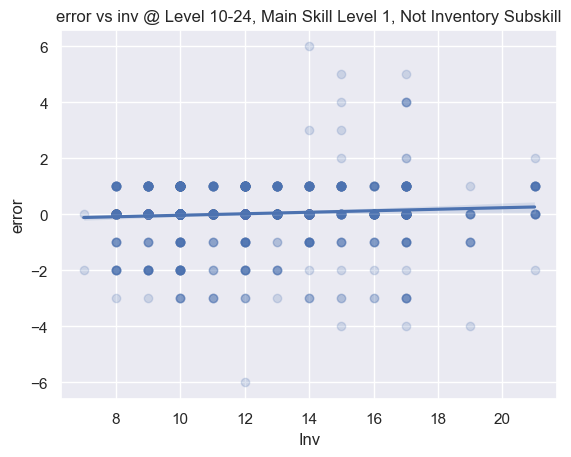

In [20]:
# Let's see what happens at level 10-24, main skill 1, and not inventory bonus 

inventory_err = ( df[["Level", "Inv", "Sub Skill 1", "error", "error2"]] 
                 .loc[ (df["Level"]>9) & (df["Level"]<25) & (df["MS lvl"]==1) & ( ~df["Sub Skill 1"].str.contains("Inventory") ) ]
                )

p = sns.regplot(data=inventory_err, x="Inv", y="error", x_jitter=0, scatter_kws={'alpha':0.2})

p.set(title='error vs inv @ Level 10-24, Main Skill Level 1, Not Inventory Subskill')

linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])
table(linearfit)

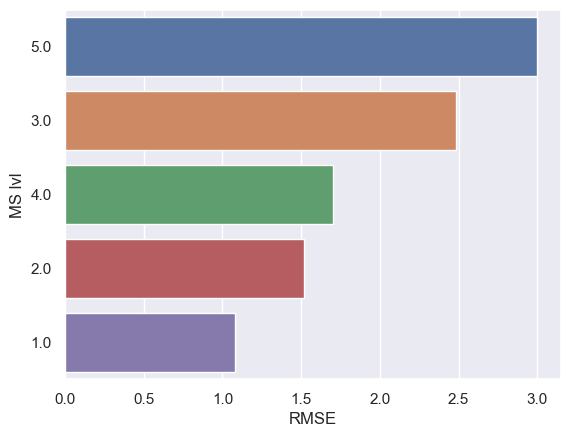

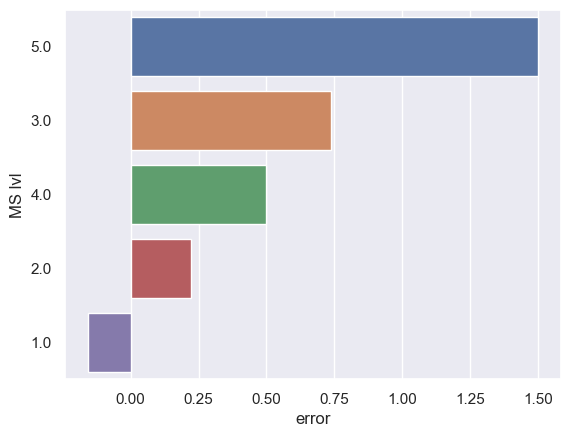

In [21]:
mslvl_err = ( df[["Level", "MS lvl", "error", "error2"]][df["Level"]==10]
                .groupby("MS lvl")
                .mean()
                .sort_values("error2", ascending = False)
                .reset_index() )

mslvl_err["RMSE"] = np.sqrt(mslvl_err["error2"])
mslvl_err["MS lvl"] = mslvl_err["MS lvl"].astype(str)

_ = plt.figure()
_ = sns.barplot(data=mslvl_err, y="MS lvl", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=mslvl_err.sort_values("error", ascending = False), y="MS lvl", x="error")


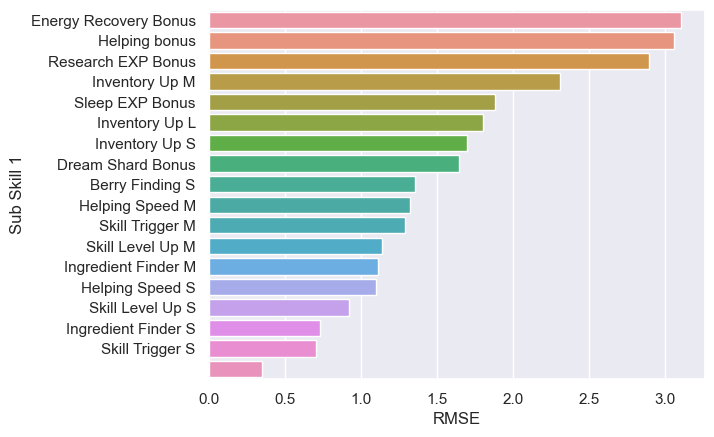

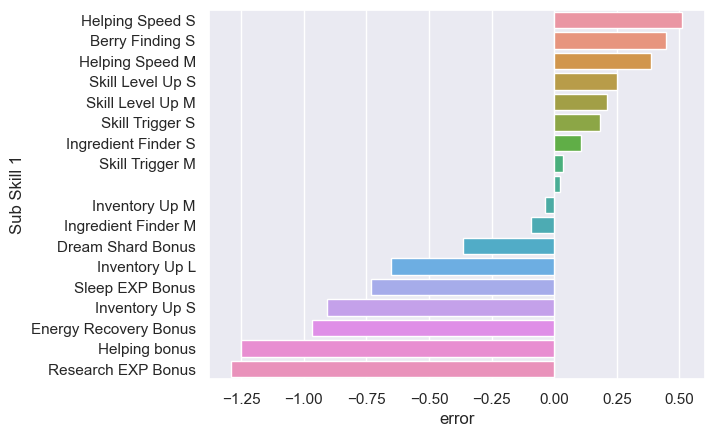

In [22]:
# Do we have more error in some skills ?

errorbyskill1 = (df[["Sub Skill 1","error","error2"]]
                .groupby("Sub Skill 1")
                .mean()
                .sort_values("error2", ascending = False)
                #.rename(columns={"error":"avg abs error"})
                .reset_index() )

errorbyskill1["RMSE"] = np.sqrt(errorbyskill1["error2"])
    
_ = plt.figure()
_ = sns.barplot(data=errorbyskill1, y="Sub Skill 1", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=errorbyskill1.sort_values("error", ascending = False), y="Sub Skill 1", x="error")

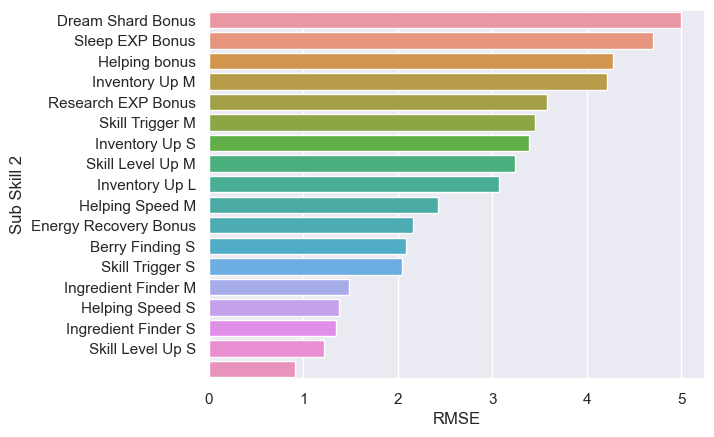

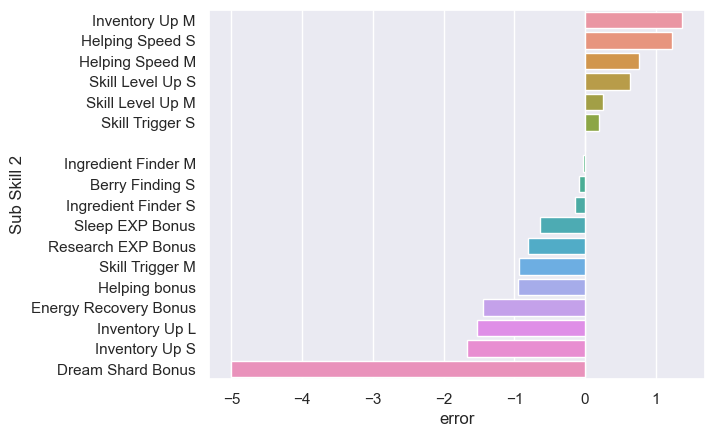

In [23]:
errorbyskill2 = (df[["Sub Skill 2","error","error2"]]
                .groupby("Sub Skill 2")
                .mean()
                .sort_values("error2", ascending = False)
                #.rename(columns={"error":"avg abs error"})
                .reset_index() )

errorbyskill2["RMSE"] = np.sqrt(errorbyskill2["error2"])
    
_ = plt.figure()
_ = sns.barplot(data=errorbyskill2, y="Sub Skill 2", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=errorbyskill2.sort_values("error", ascending = False), y="Sub Skill 2", x="error")